# Homework 2: Infotaxis
Due April 16, 2025

## Preliminaries
A robot is moving on a 25x25 grid. At each time step the robot can move up, down, left, or right for one grid cell. There is an unknown signal source in the environment emitting signals. The robot is equipped with a binary sensor with a reading {0, 1}. The measurement model can be formulated as a Bernoulli distribution, and the likelihood of the Bernoulli distribution is specified based on the source location and the robot location.

<div style="text-align: center;">
  <img src="grid.png" alt="Grid" style="border-radius: 15px;">
</div>

The measurement model in the Infotaxis problem setup. Assuming the letter 'D' is where the signal source is, the shades and the numbers represent the likelihood of registering a sensor reading of '1' if the robot is in that region. The likelihood of registering a sensor reading of '0' is 1 - L(1)


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import Image
import torch

%matplotlib inline
%matplotlib notebook


# Use the GPU if available
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEV}")

Using device: cuda


## Likelihood Function Structure

```markdown
4 4 4 4 4 4 4
0 3 3 3 3 3 0
0 0 2 2 2 0 0
0 0 0 D 0 0 0
0 0 2 2 2 0 0
0 3 3 3 3 3 0
4 4 4 4 4 4 4
```

Where D is the signal source location and the number is the reciprocal of the likelihood of reading a 1 if the robot is in that region. For example: 3 -> (1/3) likelihood of 1 and (2/3) likelihood of reading 0.

In [5]:
# Grid constants and initialization
GRID_SIZE = 25
TOTAL_CELLS = GRID_SIZE * GRID_SIZE

ACTIONS = torch.tensor(
    [
        [-1, 0],  # up
        [1, 0],  # down
        [0, -1],  # left
        [0, 1],  # right
        [0, 0]  # stay
    ],
    device=DEV,
).float()

X = torch.arange(GRID_SIZE, device=DEV).float()
Y = torch.arange(GRID_SIZE, device=DEV).float()
X, Y = torch.meshgrid(X, Y, indexing='ij')
GRID_POSITIONS = torch.stack([X.flatten(), Y.flatten()], dim=1).to(DEV)


def in_bounds(x, y):
    return (0 <= x < GRID_SIZE) and (0 <= y < GRID_SIZE)

## Problem 1: Exploration Strategy

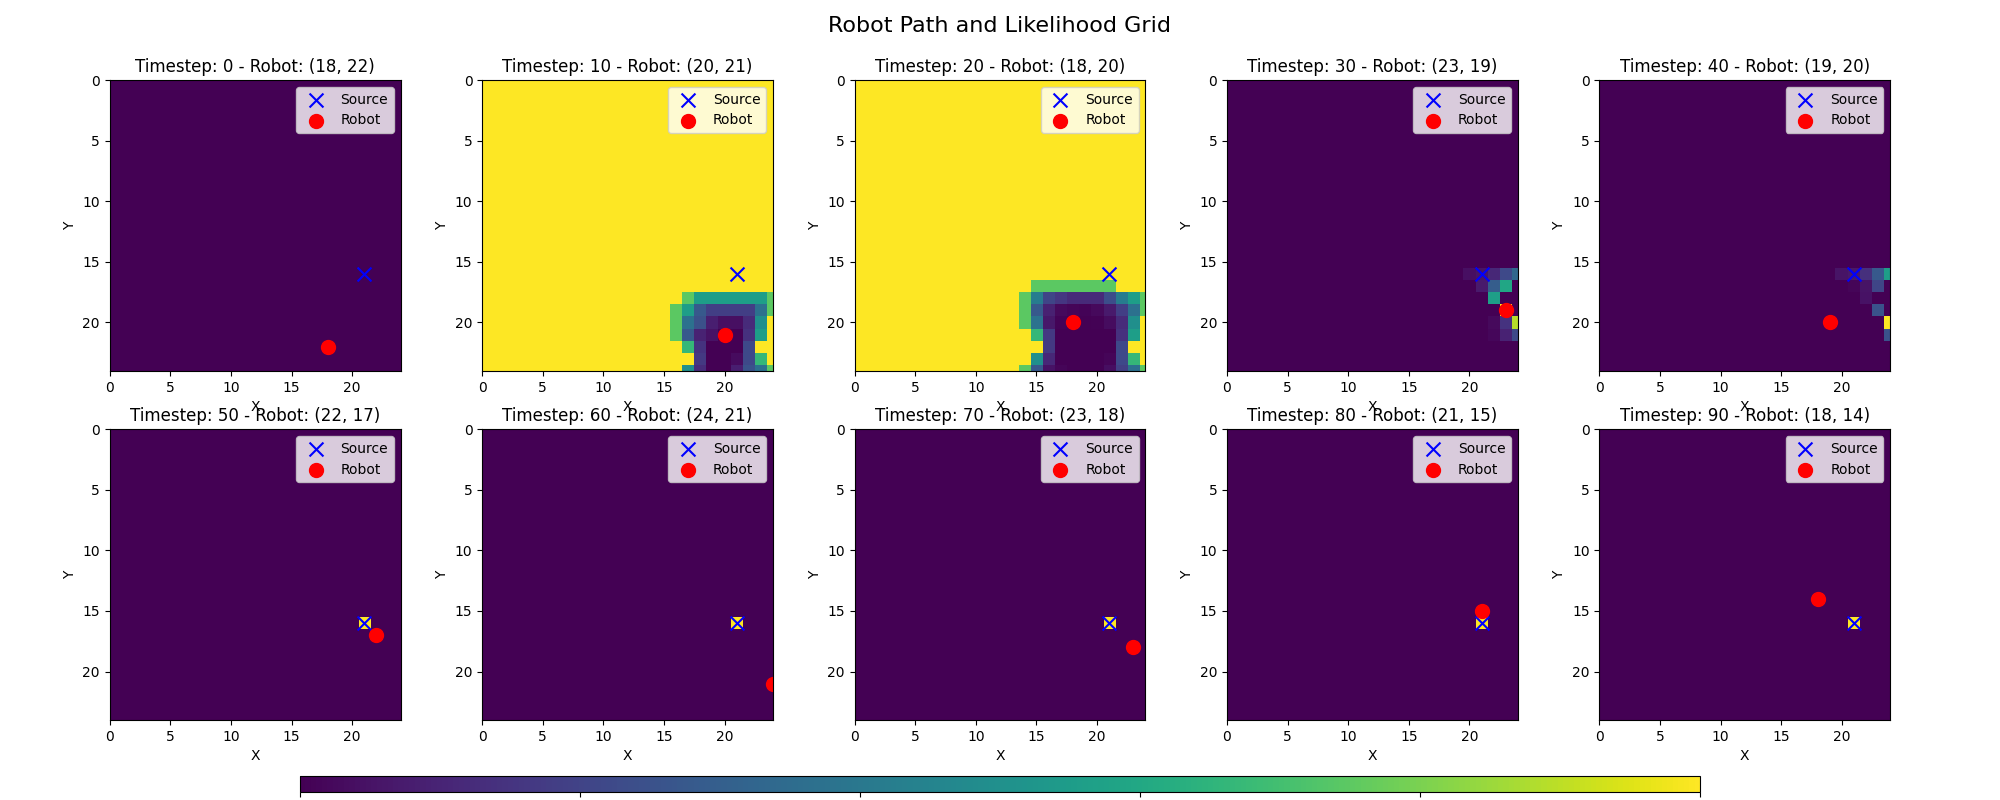

In [8]:
# Create the likelihood matrix
likelihood_matrix = np.zeros((7, 7))
likelihood_matrix[3, 3] = 1.0  # Center point has the highest likelihood

for r in range(4):  # Iterate through the top half of the grid (including the middle row)
  for c in range(7):
    # Top and bottom rows are 1/4 chance of 1
    if r == 0:
      likelihood_matrix[r, c] = 1 / 4.0
      likelihood_matrix[6 - r, c] = 1 / 4.0
    # Second row is 1/3 chance of 1
    elif r == 1 and (c != 0 and c != 6):
      likelihood_matrix[r, c] = 1 / 3.0
      likelihood_matrix[6 - r, c] = 1 / 3.0
    # Third row is 1/2 chance of 1
    elif r == 2 and (c != 0 and c != 1 and c != 5 and c != 6):
      likelihood_matrix[r, c] = 1 / 2.0
      likelihood_matrix[6 - r, c] = 1 / 2.0
    # Center point has the highest likelihood
    elif r == 3 and c == 3:
      likelihood_matrix[r, c] = 1.0

likelihood_matrix = torch.tensor(likelihood_matrix, device=DEV).float()

def create_likelihood():
    # Overlay the source likelihood on the main grid at the given source location
    # Initialize with uniform distribution
    L = torch.ones((GRID_SIZE, GRID_SIZE), device=DEV)
    # Normalize the likelihood grid
    L /= L.sum()
    return L

def local_measurement_likelihood(sensor, source):
  dx = sensor[0] - (source[0] - 3)
  dy = sensor[1] - (source[1] - 3)
  if (0 <= dx < 7).item() and (0 <= dy < 7).item():
      return likelihood_matrix[dy.long(), dx.long()]
  else:
    return torch.tensor(1e-6, device=DEV)

def full_measurement_likelihood(robot):
  # Initialize likelihood grid
  likelihood = torch.ones((GRID_SIZE, GRID_SIZE), device=DEV) / TOTAL_CELLS
  # Iterate over all grid positions
  for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
      # Compute likelihood for each grid position
      likelihood[j, i] = local_measurement_likelihood(robot, torch.tensor([i, j], device=DEV).long())
  return likelihood

def simulate_measurement(robot, source):
  return torch.bernoulli(local_measurement_likelihood(robot, source)).item()

def bayesian_update(belief, measurement, robot):
  Ls = full_measurement_likelihood(robot).view(GRID_SIZE, GRID_SIZE)
  # Reshape to match the belief tensor shape
  if measurement == 0:
    belief *= (1 - Ls)
  else:
    belief *= Ls
  # Normalize the belief
  belief /= belief.sum()
  return belief

def generate_robot_action(robot, visited, last_action=None):
    # visited is a grid_size x grid_size tensor that indicates the occurrences of each cell being visited
    action_to_inverse = {
      0: 1,  # up -> down
      1: 0,  # down -> up
      2: 3,  # left -> right
      3: 2,  # right -> left
      4: 4   # stay -> stay
    }
    action_weights = torch.zeros(len(ACTIONS), device=DEV)
    backtracking_penalty = 0.5
    visit_penalty = 2.0
    for i, a in enumerate(ACTIONS):
      candidate_pos = robot + a
      if not in_bounds(candidate_pos[0], candidate_pos[1]):
        # If the action is invalid, set its weight to 0
        action_weights[i] = 0
      else:
        # Penalize the action if the cell has been visited
        visited_count = visited[candidate_pos[0].long(), candidate_pos[1].long()]
        
        # Exponential penalty
        weight = torch.exp(-visit_penalty * visited_count)
        
        # Further penalize action if it is the inverse of the last action
        if last_action is not None and i == action_to_inverse[last_action]:
          weight *= backtracking_penalty
        
        action_weights[i] = weight
    # Ensure the action weights are non-negative
    # action_weights = torch.clamp(action_weights, min=0)
    # Normalize the action weights
    action_weights /= action_weights.sum()
    
    # Sample a new action
    action = torch.multinomial(action_weights, 1).item()
    new_robot_pos = (robot + ACTIONS[action]).long()
    return new_robot_pos, action

def exploration(NUM_TIMESTEPS=100):
    # Randomly sample a source location and an initial location of the robot.
    source_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
    robot_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
    print(f"Source Location: {source_location.cpu().numpy()}")
    print(f"Initial Robot Location: {robot_location.cpu().numpy()}")
    
    # Create initial likelihood grid
    L = create_likelihood()
    
    # Store simulation states for each timestep
    robot_path = [robot_location.cpu().numpy()]
    likelihoods = [L.clone()]
    
    # Simulation
    visited = torch.zeros((GRID_SIZE, GRID_SIZE), device=DEV)
    last_action = None
    for t in range(1, NUM_TIMESTEPS):
        robot_location, last_action = generate_robot_action(
            robot_location, visited, last_action)
        visited[robot_location[0], robot_location[1]] += 1
        robot_path.append(robot_location.cpu().numpy())
        
        # Simulate measurement and update the belief
        Z = simulate_measurement(robot_location, source_location)
        L = bayesian_update(L.clone(), Z, robot_location)
        likelihoods.append(L.clone())
    return np.array(robot_path), likelihoods, source_location.cpu().numpy()

def visualize_likelihood(L):
  fig = plt.figure(figsize=(8, 8))
  plt.imshow(L.cpu().numpy(), cmap='viridis', interpolation='nearest')
  plt.xlim(0, GRID_SIZE - 1)
  plt.ylim(GRID_SIZE - 1, 0)  # Invert y-axis to match the grid coordinates
  plt.colorbar(label='Likelihood', orientation='horizontal')
  plt.title('Likelihood Grid')
  plt.show()
  
def create_exploration_plots(problem, source_location, robot_path, L_list, NUM_TIMESTEPS=100):
    # Visualize the likelihood grid with heatmap
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    timesteps_per_plot = NUM_TIMESTEPS // 10

    for i, ax in enumerate(axes.flat):
        timestep = i * timesteps_per_plot
        likelihood = L_list[timestep].clone()
        ax.imshow(likelihood.cpu().numpy(), cmap='viridis', interpolation='nearest')
        ax.set_xlim(0, GRID_SIZE - 1)
        # Invert y-axis to match the grid coordinates
        ax.set_ylim(GRID_SIZE - 1, 0)
        ax.set_aspect('equal')
        if isinstance(source_location, torch.Tensor):
            source_x, source_y = source_location[0].cpu().numpy(), source_location[1].cpu().numpy()
        else:
            source_x, source_y = source_location[0], source_location[1]
        
        ax.scatter(source_x, source_y, c='blue', label='Source', marker='x', s=100)
        ax.scatter(robot_path[timestep, 0], robot_path[timestep, 1], c='red', label='Robot', marker='o', s=100)
        ax.set_title(f'Timestep: {timestep} - Robot: ({robot_path[timestep, 0]}, {robot_path[timestep, 1]})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()
        ax.grid(False)
    # Add a colorbar underneath all subplots
    cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.02])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Likelihood')
    # Adjust layout and titlea
    # plt.tight_layout()
    plt.suptitle('Robot Path and Likelihood Grid', fontsize=16)
    plt.subplots_adjust(top=0.90, bottom=0.1, left=0.05, right=0.95)
    plt.savefig(f"problem{problem}.png")
  
# robot_path, L_list, source = exploration()
# create_exploration_plots(source, robot_path, L_list)

Image(filename='problem1.png')

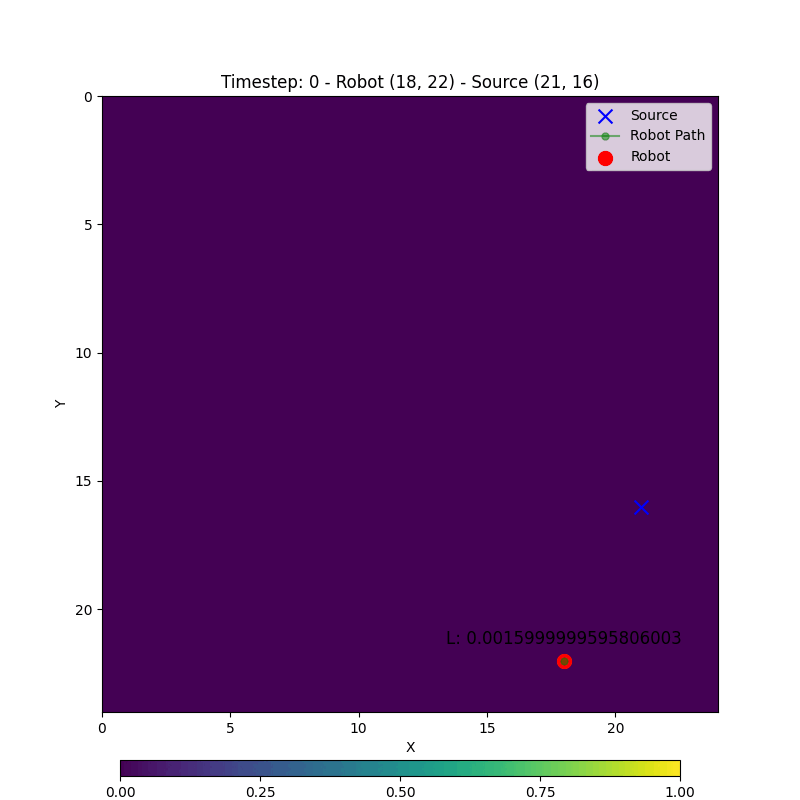

In [ ]:
# Animate the robot's path and the likelihood grid
fig, ax = plt.subplots(figsize=(8, 8))


def update(frame):
  ax.clear()
  # Display current likelihood grid as heatmap
  L_current = L_list[frame]
  im = ax.imshow(L_current.cpu().numpy(),
                 cmap='viridis', interpolation='nearest')

  # Plot the source location
  if isinstance(source, torch.Tensor):
      source_x, source_y = source[0].cpu().numpy(), source[1].cpu().numpy()
  else:
      source_x, source_y = source[0], source[1]
  ax.scatter(source_x, source_y, c='blue', label='Source',
             marker='x', s=100)

  # Plot robot path so far
  path = robot_path[:frame + 1]
  robot_x = int(path[frame, 0])
  robot_y = int(path[frame, 1])
  ax.plot(path[:, 0], path[:, 1], color='green', marker='o',
          markersize=5, label='Robot Path', alpha=0.5)
  ax.scatter(robot_x, robot_y, color='red', marker='o', s=100, label='Robot')
  # Likelihood at the robot's position
  L_robot_position = L_current[robot_y, robot_x]
  ax.text(robot_x, robot_y - 0.5,
          f'L: {L_robot_position}', fontsize=12,
          ha='center', va='bottom', color='black')
  # Set x,y limits
  ax.set_xlim(0, GRID_SIZE - 1)
  ax.set_ylim(GRID_SIZE - 1, 0)
  ax.set_title(
      f'Timestep: {frame} - Robot ({path[frame, 0]}, {path[frame, 1]}) - Source ({source[0]}, {source[1]})'
  )
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.legend(loc='upper right')
  ax.grid(False)
  return im,


# Add the colorbar to the figure
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', pad=0.1)
cbar.set_ticks(np.linspace(0, 1, 5))
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Likelihood')

# Create the animation
ani = anim.FuncAnimation(fig, update, frames=len(
    L_list), interval=200, blit=False)
# Save the animation
# ani.save('robot_exploration.gif', writer='imagemagick', fps=5)

Image(filename='robot_exploration.gif')

## Problem 2: Infotaxis Algorithm

In [9]:
def entropy(belief):
    return -torch.sum(belief * torch.log(belief + 1e-10))

def expected_information_gain(robot_candidate_pos, belief):
    sensor_likelihood = full_measurement_likelihood(robot_candidate_pos)
    # Probability of obtaining measurement Z=1
    p1 = (belief * sensor_likelihood).sum()
    # Probability of obtaining measurement Z=0
    p0 = 1 - p1
    # Compute the posterier belief for each outcome
    if p1 > 0:
        H1 = entropy(belief * sensor_likelihood / p1)
    else:
        H1 = 0
    if p0 > 0:
        H0 = entropy(belief * (1 - sensor_likelihood) / p0)
    else:
        H0 = 0
    # Compute the expected information gain
    H_expected = p1*H1 + p0*H0
    # Current entropy
    H_current = entropy(belief)
    # Information gain
    information_gain = H_current - H_expected
    return information_gain

def infotaxis_action(robot, belief):
    # Compute the expected information gain for each action
    action_gains = torch.zeros(len(ACTIONS), device=DEV)
    for i, a in enumerate(ACTIONS):
        candidate_pos = robot + a
        if in_bounds(candidate_pos[0], candidate_pos[1]):
            action_gains[i] = expected_information_gain(candidate_pos, belief)
        else:
            action_gains[i] = -1e6  # Invalid actions get a very low score
    # Select the action with the maximum information gain
    action = torch.argmax(action_gains).item()
    new_robot_pos = (robot + ACTIONS[action]).long()
    return new_robot_pos, action

def infotaxis_exploration(NUM_TIMESTEPS=100):
    # Randomly sample a source location and an initial location of the robot.
    source_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
    robot_location = torch.randint(0, GRID_SIZE, (2,), device=DEV)
    print(f"Source Location: {source_location.cpu().numpy()}")
    print(f"Initial Robot Location: {robot_location.cpu().numpy()}")
    
    # Create initial likelihood grid
    L = create_likelihood()
    
    # Store simulation states for each timestep
    robot_path = [robot_location.cpu().numpy()]
    likelihoods = [L.clone()]
    
    # Simulation
    visited = torch.zeros((GRID_SIZE, GRID_SIZE), device=DEV)
    last_action = None
    for t in range(1, NUM_TIMESTEPS):
        robot_location, last_action = infotaxis_action(robot_location, L)
        visited[robot_location[0], robot_location[1]] += 1
        robot_path.append(robot_location.cpu().numpy())
        
        # Simulate measurement and update the belief
        Z = simulate_measurement(robot_location, source_location)
        L = bayesian_update(L.clone(), Z, robot_location)
        likelihoods.append(L.clone())
    return np.array(robot_path), likelihoods, source_location.cpu().numpy()

Source Location: [11 24]
Initial Robot Location: [15 10]


<IPython.core.display.Javascript object>

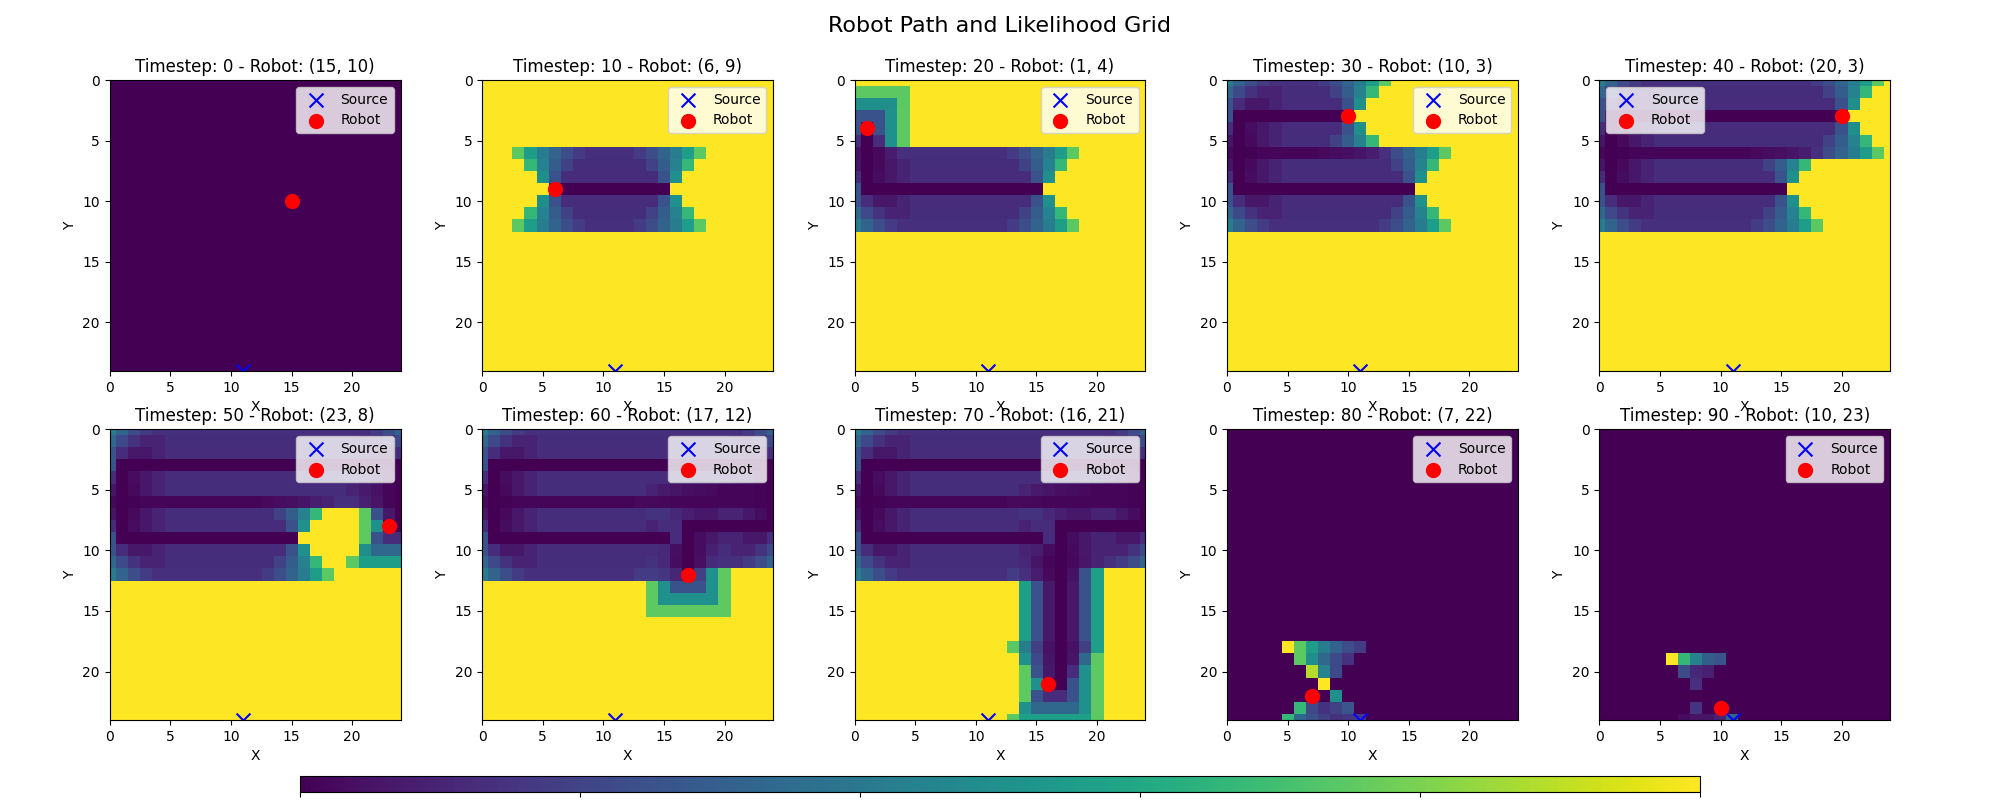

In [10]:
robot_path, L_list, source = infotaxis_exploration()
create_exploration_plots(2, source, robot_path, L_list)

Image(filename='problem2.png')

<IPython.core.display.Javascript object>

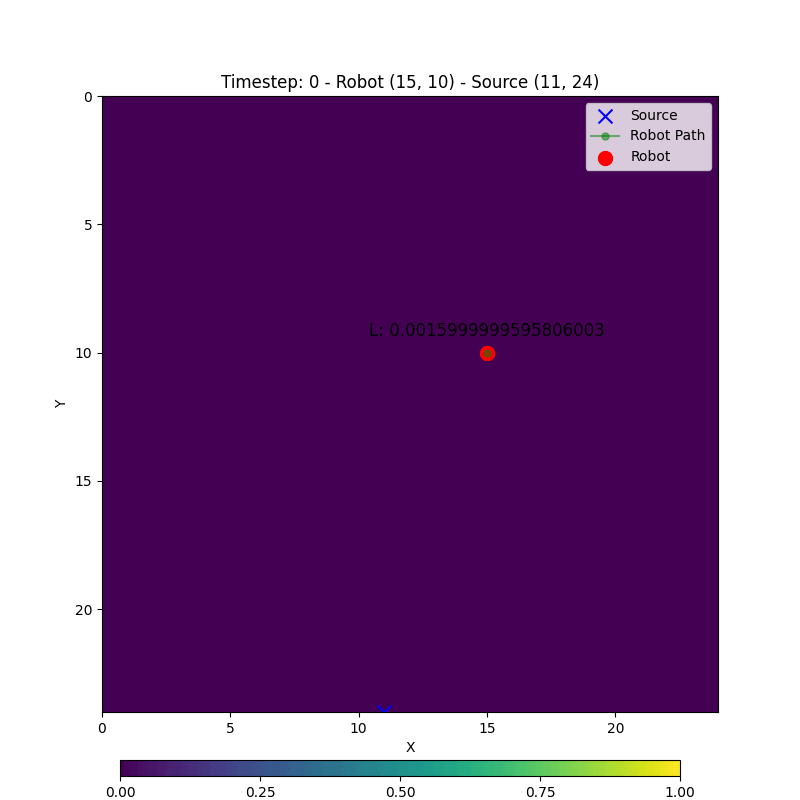

In [11]:
# Animate the robot's path and the likelihood grid
fig, ax = plt.subplots(figsize=(8, 8))

def update(frame):
  ax.clear()
  # Display current likelihood grid as heatmap
  L_current = L_list[frame]
  im = ax.imshow(L_current.cpu().numpy(),
                 cmap='viridis', interpolation='nearest')

  # Plot the source location
  if isinstance(source, torch.Tensor):
      source_x, source_y = source[0].cpu().numpy(), source[1].cpu().numpy()
  else:
      source_x, source_y = source[0], source[1]
  ax.scatter(source_x, source_y, c='blue', label='Source',
             marker='x', s=100)

  # Plot robot path so far
  path = robot_path[:frame + 1]
  robot_x = int(path[frame, 0])
  robot_y = int(path[frame, 1])
  ax.plot(path[:, 0], path[:, 1], color='green', marker='o',
          markersize=5, label='Robot Path', alpha=0.5)
  ax.scatter(robot_x, robot_y, color='red', marker='o', s=100, label='Robot')
  # Likelihood at the robot's position
  L_robot_position = L_current[robot_y, robot_x]
  ax.text(robot_x, robot_y - 0.5,
          f'L: {L_robot_position}', fontsize=12,
          ha='center', va='bottom', color='black')
  # Set x,y limits
  ax.set_xlim(0, GRID_SIZE - 1)
  ax.set_ylim(GRID_SIZE - 1, 0)
  ax.set_title(
      f'Timestep: {frame} - Robot ({path[frame, 0]}, {path[frame, 1]}) - Source ({source[0]}, {source[1]})'
  )
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.legend(loc='upper right')
  ax.grid(False)
  return im,


# Add the colorbar to the figure
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', pad=0.1)
cbar.set_ticks(np.linspace(0, 1, 5))
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Likelihood')

# Create the animation
ani = anim.FuncAnimation(fig, update, frames=len(
    L_list), interval=200, blit=False)
# Save the animation
ani.save('robot_infotaxis.gif', writer='imagemagick', fps=5)

Image(filename='robot_infotaxis.gif')